# Synthetic Dataset & Scalability
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure and determine their scalability to datasets with a large number of observations.__  

As a reminder, unique pairwise distances in a dataset with _n_ cells is calculated as:  
$$D=(n*(n-1))/2$$  
  
To benchmark these techniques, we are using a **"Swiss Roll"** dataset built using `sklearn.datasets.make_swiss_roll()`.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

In [3]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

In [4]:
# create dictionary for dumping results into
final_distance_stats = {
    'Swiss':{'R':{}, 'EMD':{}, 'Knn Pres.':{}},
    'Gauss':{'R':{}, 'EMD':{}, 'Knn Pres.':{}}
                       }

---
### 1K-Point Swiss Roll

In [5]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

In [6]:
X[:,0] = X[:,0] + 50

In [7]:
X2, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

In [8]:
X3 = np.append(X2, values=X, axis=0)

In [9]:
t3 = np.append(t, values=t, axis=0)

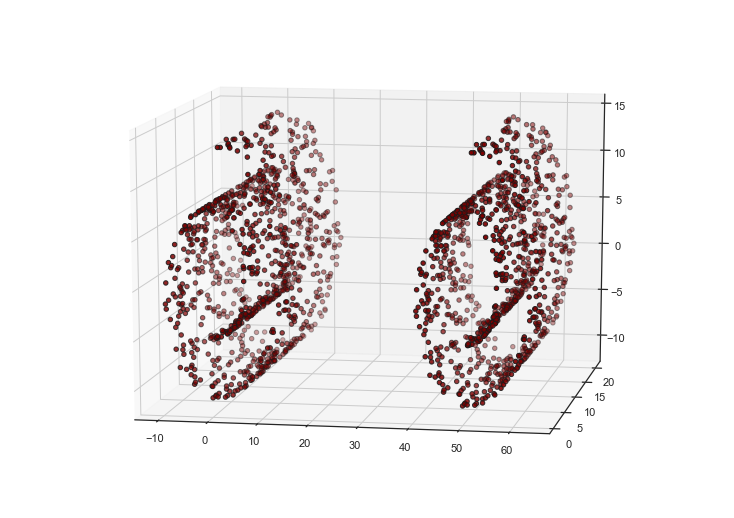

In [10]:
fig = plt.figure(figsize=(10,7))
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], color=plt.cm.jet(t3), s=20, edgecolor='k')

In [11]:
swiss = sc.AnnData(X=X3) # initialize AnnData
swiss.obs['pos'] = t3 # add univariate position according to main dim of manifold to .obs

swiss

AnnData object with n_obs × n_vars = 2000 × 3 
    obs: 'pos'

In [12]:
# perform PCA
%time sc.tl.pca(swiss, n_comps=2)

CPU times: user 39.4 ms, sys: 14.3 ms, total: 53.7 ms
Wall time: 78.7 ms


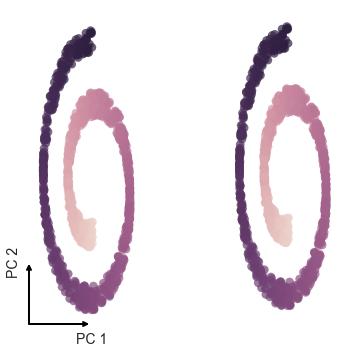

In [13]:
DR_plot(dim_name='PC').plot(swiss.obsm['X_pca'], color=swiss.obs['pos'])

In [14]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(swiss, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 5.95 s, sys: 276 ms, total: 6.22 s
Wall time: 6.32 s


In [15]:
# perform UMAP
%time sc.tl.umap(swiss, random_state=18)

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 5.28 s, sys: 67.5 ms, total: 5.35 s
Wall time: 5.34 s


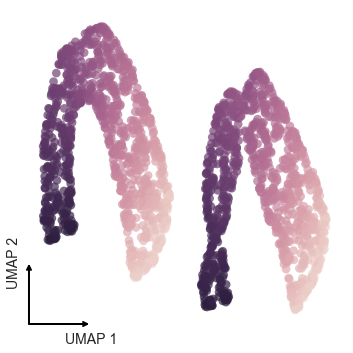

In [16]:
DR_plot(dim_name='UMAP').plot(swiss.obsm['X_umap'], color=swiss.obs['pos'])

In [17]:
# perform t-SNE
%time sc.tl.tsne(swiss, use_rep='X', perplexity=30, random_state=18)

CPU times: user 11.1 s, sys: 178 ms, total: 11.2 s
Wall time: 11.6 s


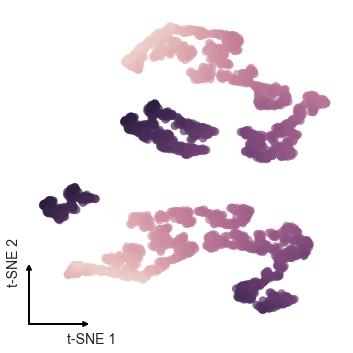

In [18]:
DR_plot(dim_name='t-SNE').plot(swiss.obsm['X_tsne'], color=swiss.obs['pos'])

In [19]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(swiss, latent='X_pca', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))
final_distance_stats['Swiss']['R']['PCA'], final_distance_stats['Swiss']['EMD']['PCA'], final_distance_stats['Swiss']['Knn Pres.']['PCA'] = pca_corr[0], pca_EMD, pca_knnP

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X
30-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation
Done!
CPU times: user 1.54 s, sys: 690 ms, total: 2.23 s
Wall time: 1.93 s
R: 0.9937
EMD: 0.0227
Knn %: 97.7034


In [20]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(swiss, latent='X_tsne', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats['Swiss']['R']['t-SNE'], final_distance_stats['Swiss']['EMD']['t-SNE'], final_distance_stats['Swiss']['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation
Done!
CPU times: user 1.25 s, sys: 324 ms, total: 1.57 s
Wall time: 1.25 s
R: 0.6742
EMD: 0.0703
Knn %: 98.3078


In [21]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(swiss, latent='X_umap', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats['Swiss']['R']['UMAP'], final_distance_stats['Swiss']['EMD']['UMAP'], final_distance_stats['Swiss']['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 1.27 s, sys: 314 ms, total: 1.59 s
Wall time: 1.31 s
R: 0.7832
EMD: 0.0673
Knn %: 98.3478


<Figure size 288x288 with 0 Axes>

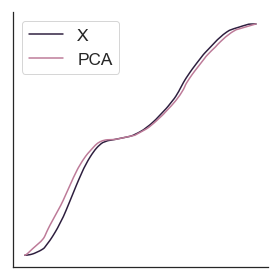

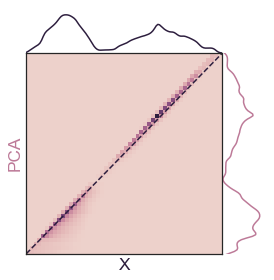

In [22]:
plt.figure(figsize=(4,4))
SP_plot(swiss.uns['X_norm_distances'], swiss.uns['X_pca_norm_distances'], labels=['X','PCA']).plot_cumulative_distributions()
SP_plot(swiss.uns['X_norm_distances'], swiss.uns['X_pca_norm_distances'], labels=['X','PCA']).joint_plot_distance_correlation()

<Figure size 288x288 with 0 Axes>

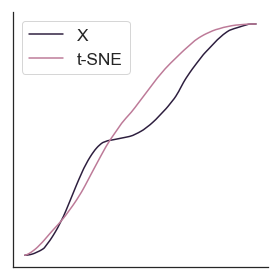

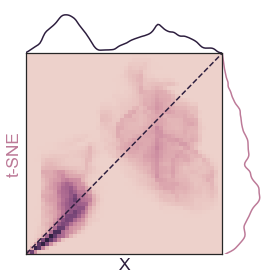

In [23]:
plt.figure(figsize=(4,4))
SP_plot(swiss.uns['X_norm_distances'], swiss.uns['X_tsne_norm_distances'], labels=['X','t-SNE']).plot_cumulative_distributions()
SP_plot(swiss.uns['X_norm_distances'], swiss.uns['X_tsne_norm_distances'], labels=['X','t-SNE']).joint_plot_distance_correlation()

<Figure size 288x288 with 0 Axes>

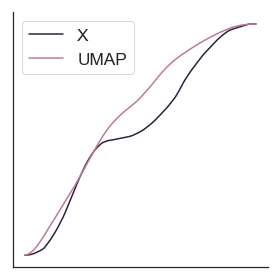

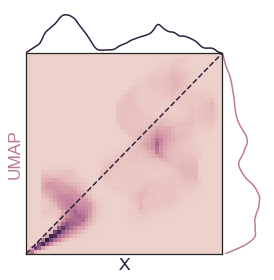

In [24]:
plt.figure(figsize=(4,4))
SP_plot(swiss.uns['X_norm_distances'], swiss.uns['X_umap_norm_distances'], labels=['X','UMAP']).plot_cumulative_distributions()
SP_plot(swiss.uns['X_norm_distances'], swiss.uns['X_umap_norm_distances'], labels=['X','UMAP']).joint_plot_distance_correlation()

---

In [25]:
X1, y1 = datasets.make_gaussian_quantiles(cov=1, n_samples=1000, n_features=3, random_state=1)

In [26]:
X1[:,0] = X1[:,0] + 7

In [27]:
X2, y2 = datasets.make_gaussian_quantiles(cov=1, n_samples=1000, n_features=3, random_state=2)

In [28]:
X3 = np.append(X2, values=X1, axis=0)

In [29]:
X3 = np.append(X3, X3, axis=1)

In [30]:
y3 = np.append(y2, values=y1, axis=0)

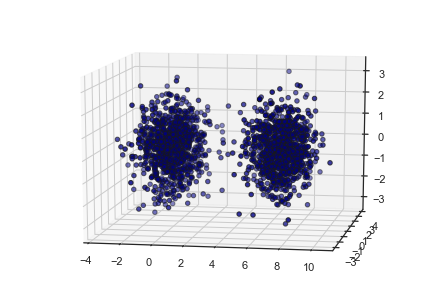

In [31]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], color=plt.cm.jet(y3), s=20, edgecolor='k')

In [32]:
gauss = sc.AnnData(X=X3) # initialize AnnData
gauss.obs['class'] = y3 # add univariate position according to main dim of manifold to .obs
gauss

AnnData object with n_obs × n_vars = 2000 × 6 
    obs: 'class'

In [33]:
# perform PCA
%time sc.tl.pca(gauss, n_comps=2)

CPU times: user 3.44 ms, sys: 909 µs, total: 4.35 ms
Wall time: 4.84 ms


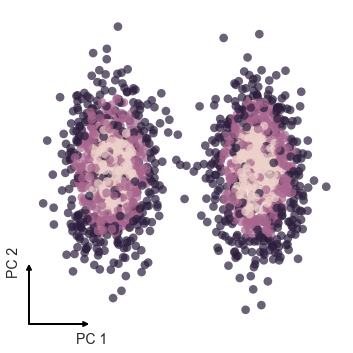

In [34]:
DR_plot(dim_name='PC').plot(gauss.obsm['X_pca'], color=gauss.obs['class'])

In [35]:
# create neighborhood graphs from PCA results for UMAP
%time sc.pp.neighbors(gauss, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

CPU times: user 320 ms, sys: 255 ms, total: 575 ms
Wall time: 476 ms


In [36]:
# perform UMAP
%time sc.tl.umap(gauss, random_state=18)

CPU times: user 3.62 s, sys: 52.7 ms, total: 3.67 s
Wall time: 3.82 s


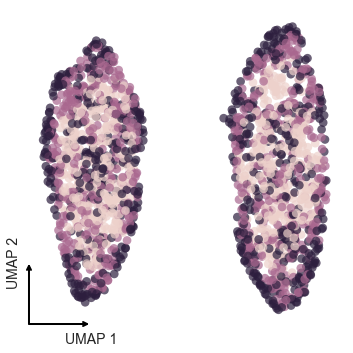

In [37]:
DR_plot(dim_name='UMAP').plot(gauss.obsm['X_umap'], color=gauss.obs['class'])

In [38]:
# perform t-SNE
%time sc.tl.tsne(gauss, use_rep='X', perplexity=30, random_state=18)

CPU times: user 11 s, sys: 185 ms, total: 11.2 s
Wall time: 11.3 s


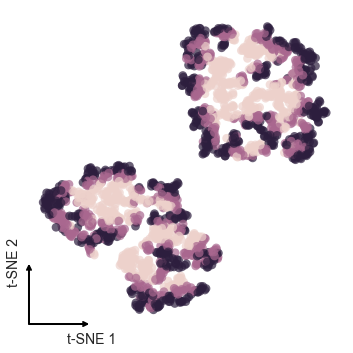

In [39]:
DR_plot(dim_name='t-SNE').plot(gauss.obsm['X_tsne'], color=gauss.obs['class'])

In [40]:
%time pca_corr, pca_EMD, pca_knnP = structure_preservation_sc(gauss, latent='X_pca', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(pca_corr[0],4), round(pca_EMD,4), round(pca_knnP,4)))
final_distance_stats['Gauss']['R']['PCA'], final_distance_stats['Gauss']['EMD']['PCA'], final_distance_stats['Gauss']['Knn Pres.']['PCA'] = pca_corr[0], pca_EMD, pca_knnP

Calculating unique distances for native space, X
Calculating unique distances for latent space, X_pca
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X
30-nearest neighbor calculation for latent space, X_pca
Determining nearest neighbor preservation
Done!
CPU times: user 1.6 s, sys: 555 ms, total: 2.15 s
Wall time: 1.6 s
R: 0.9886
EMD: 0.0208
Knn %: 97.6507


In [41]:
%time tsne_corr, tsne_EMD, tsne_knnP = structure_preservation_sc(gauss, latent='X_tsne', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tsne_corr[0],4), round(tsne_EMD,4), round(tsne_knnP,4)))
final_distance_stats['Gauss']['R']['t-SNE'], final_distance_stats['Gauss']['EMD']['t-SNE'], final_distance_stats['Gauss']['Knn Pres.']['t-SNE'] = tsne_corr[0], tsne_EMD, tsne_knnP

Calculating unique distances for latent space, X_tsne
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, X_tsne
Determining nearest neighbor preservation
Done!
CPU times: user 1.24 s, sys: 327 ms, total: 1.56 s
Wall time: 1.26 s
R: 0.9349
EMD: 0.0537
Knn %: 98.0067


In [42]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(gauss, latent='X_umap', native='X', k=30)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))
final_distance_stats['Gauss']['R']['UMAP'], final_distance_stats['Gauss']['EMD']['UMAP'], final_distance_stats['Gauss']['Knn Pres.']['UMAP'] = umap_corr[0], umap_EMD, umap_knnP

Calculating unique distances for latent space, X_umap
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 1.26 s, sys: 349 ms, total: 1.61 s
Wall time: 1.34 s
R: 0.9507
EMD: 0.0698
Knn %: 97.7736


<Figure size 288x288 with 0 Axes>

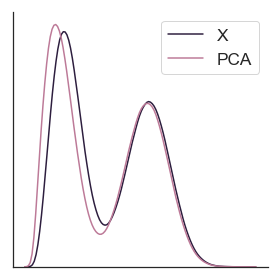

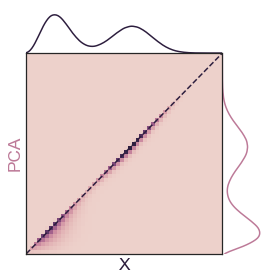

In [59]:
plt.figure(figsize=(4,4))
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_pca_norm_distances'], labels=['X','PCA']).plot_distributions()
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_pca_norm_distances'], labels=['X','PCA']).joint_plot_distance_correlation()

<Figure size 288x288 with 0 Axes>

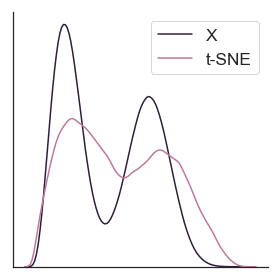

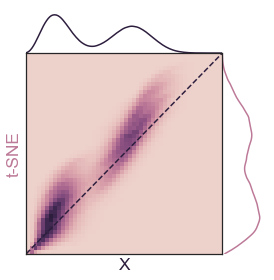

In [58]:
plt.figure(figsize=(4,4))
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_tsne_norm_distances'], labels=['X','t-SNE']).plot_distributions()
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_tsne_norm_distances'], labels=['X','t-SNE']).joint_plot_distance_correlation()

<Figure size 288x288 with 0 Axes>

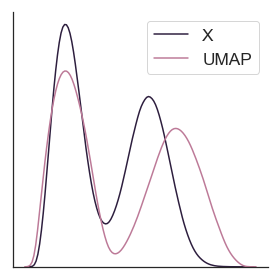

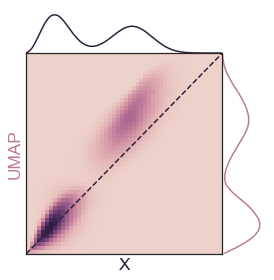

In [57]:
plt.figure(figsize=(4,4))
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_umap_norm_distances'], labels=['X','UMAP']).plot_distributions()
SP_plot(gauss.uns['X_norm_distances'], gauss.uns['X_umap_norm_distances'], labels=['X','UMAP']).joint_plot_distance_correlation()

In [46]:
stats_swiss = pd.DataFrame(final_distance_stats['Swiss'])
stats_swiss['Dataset'] = 'Swiss Roll'
stats_gauss = pd.DataFrame(final_distance_stats['Gauss'])
stats_gauss['Dataset'] = 'Gaussian'

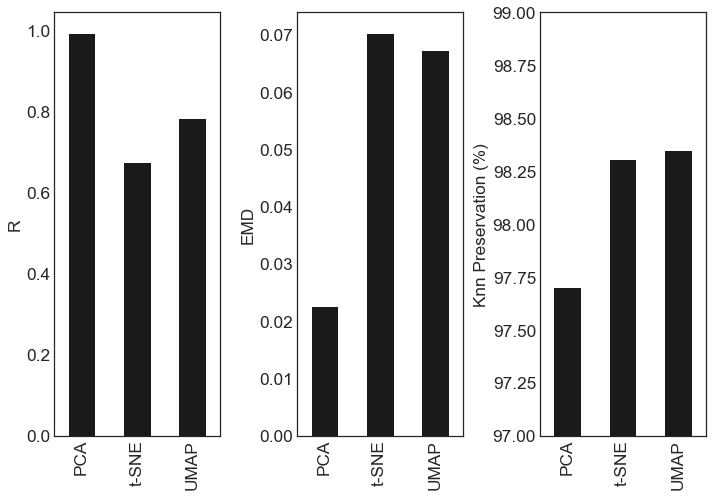

In [60]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,7))
    stats_swiss[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    stats_swiss[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    stats_swiss[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R', fontsize='xx-large')
    axes[1].set_ylabel('EMD', fontsize='xx-large')
    axes[2].set_ylim([97, 99])
    axes[2].set_ylabel('Knn Preservation (%)', fontsize='xx-large')
    axes[0].tick_params(labelsize='xx-large')
    axes[1].tick_params(labelsize='xx-large')
    axes[2].tick_params(labelsize='xx-large')
    plt.tight_layout()
    plt.savefig('outputs/plots/doubleswiss_stats.png', dpi=1000)

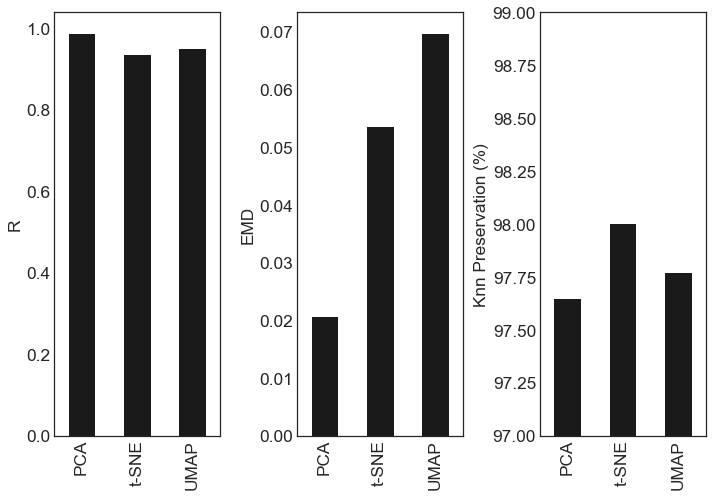

In [61]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,7))
    stats_gauss[['R']].plot(ax=axes[0],kind='bar', legend=False, color='k')
    stats_gauss[['EMD']].plot(ax=axes[1],kind='bar', legend=False, color='k')
    stats_gauss[['Knn Pres.']].plot(ax=axes[2],kind='bar', legend=False, color='k')
    axes[0].set_ylabel('R', fontsize='xx-large')
    axes[1].set_ylabel('EMD', fontsize='xx-large')
    axes[2].set_ylim([97, 99])
    axes[2].set_ylabel('Knn Preservation (%)', fontsize='xx-large')
    axes[0].tick_params(labelsize='xx-large')
    axes[1].tick_params(labelsize='xx-large')
    axes[2].tick_params(labelsize='xx-large')
    plt.tight_layout()
    plt.savefig('outputs/plots/doublegauss_stats.png', dpi=1000)